PyTorch: 2.6.0+cu124, TensorFlow: 2.18.0
CUDA: True
TRAINING ALL MODELS

=== Training Custom Transformer ===
Epoch 1/6 | Train Loss: 1.0011 BA: 0.2448 | Val Loss: 0.8354 BA: 0.3845
Epoch 2/6 | Train Loss: 0.7439 BA: 0.4051 | Val Loss: 1.0801 BA: 0.3061
Epoch 3/6 | Train Loss: 0.5885 BA: 0.5163 | Val Loss: 0.5557 BA: 0.5472
Epoch 4/6 | Train Loss: 0.4886 BA: 0.5826 | Val Loss: 0.5148 BA: 0.5685
Epoch 5/6 | Train Loss: 0.4164 BA: 0.6403 | Val Loss: 0.4889 BA: 0.5883
Epoch 6/6 | Train Loss: 0.3955 BA: 0.6582 | Val Loss: 0.4731 BA: 0.6005


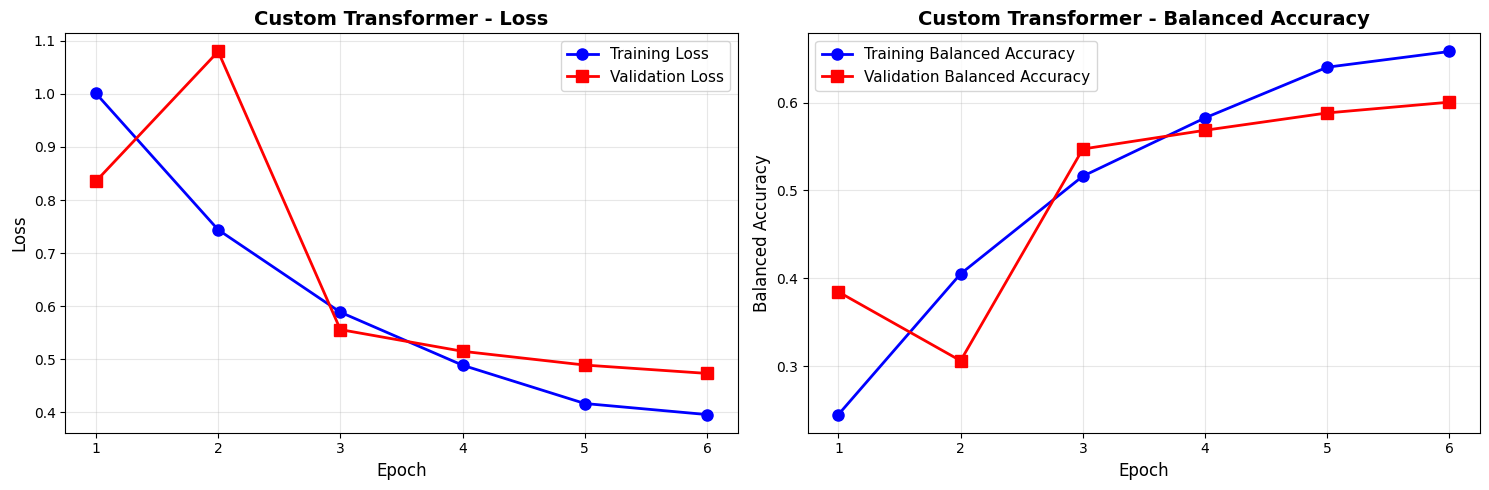

Saved Custom Transformer training history plot


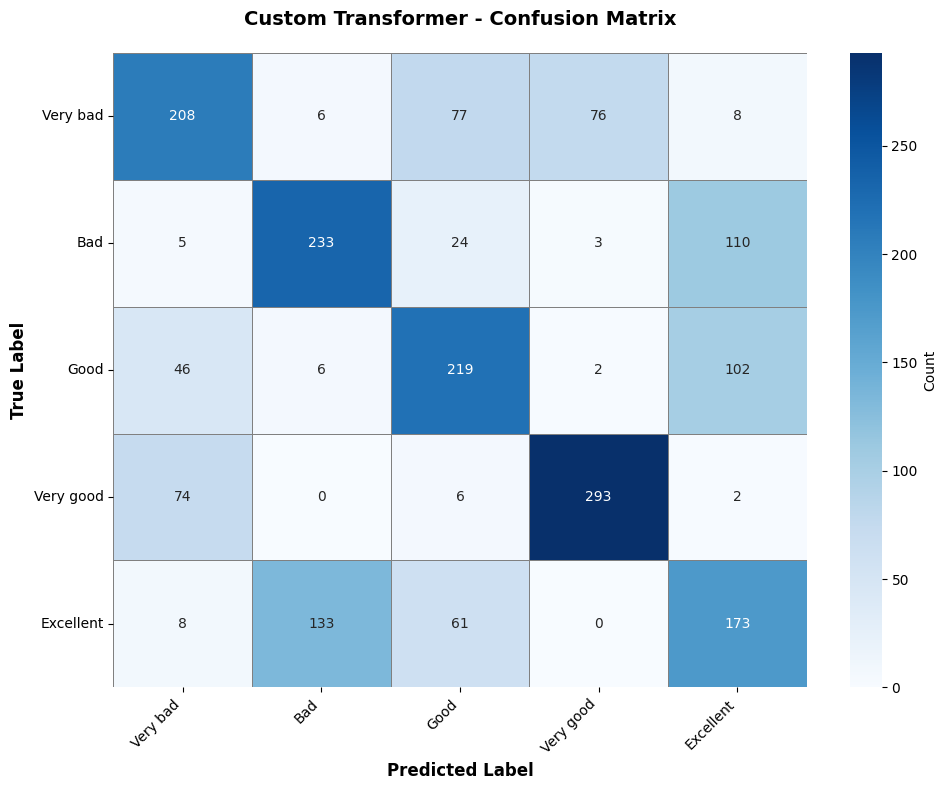

Saved Custom Transformer confusion matrix
Custom Transformer Best Val BA: 0.6005

=== Training TensorFlow Models ===

Training BiLSTM


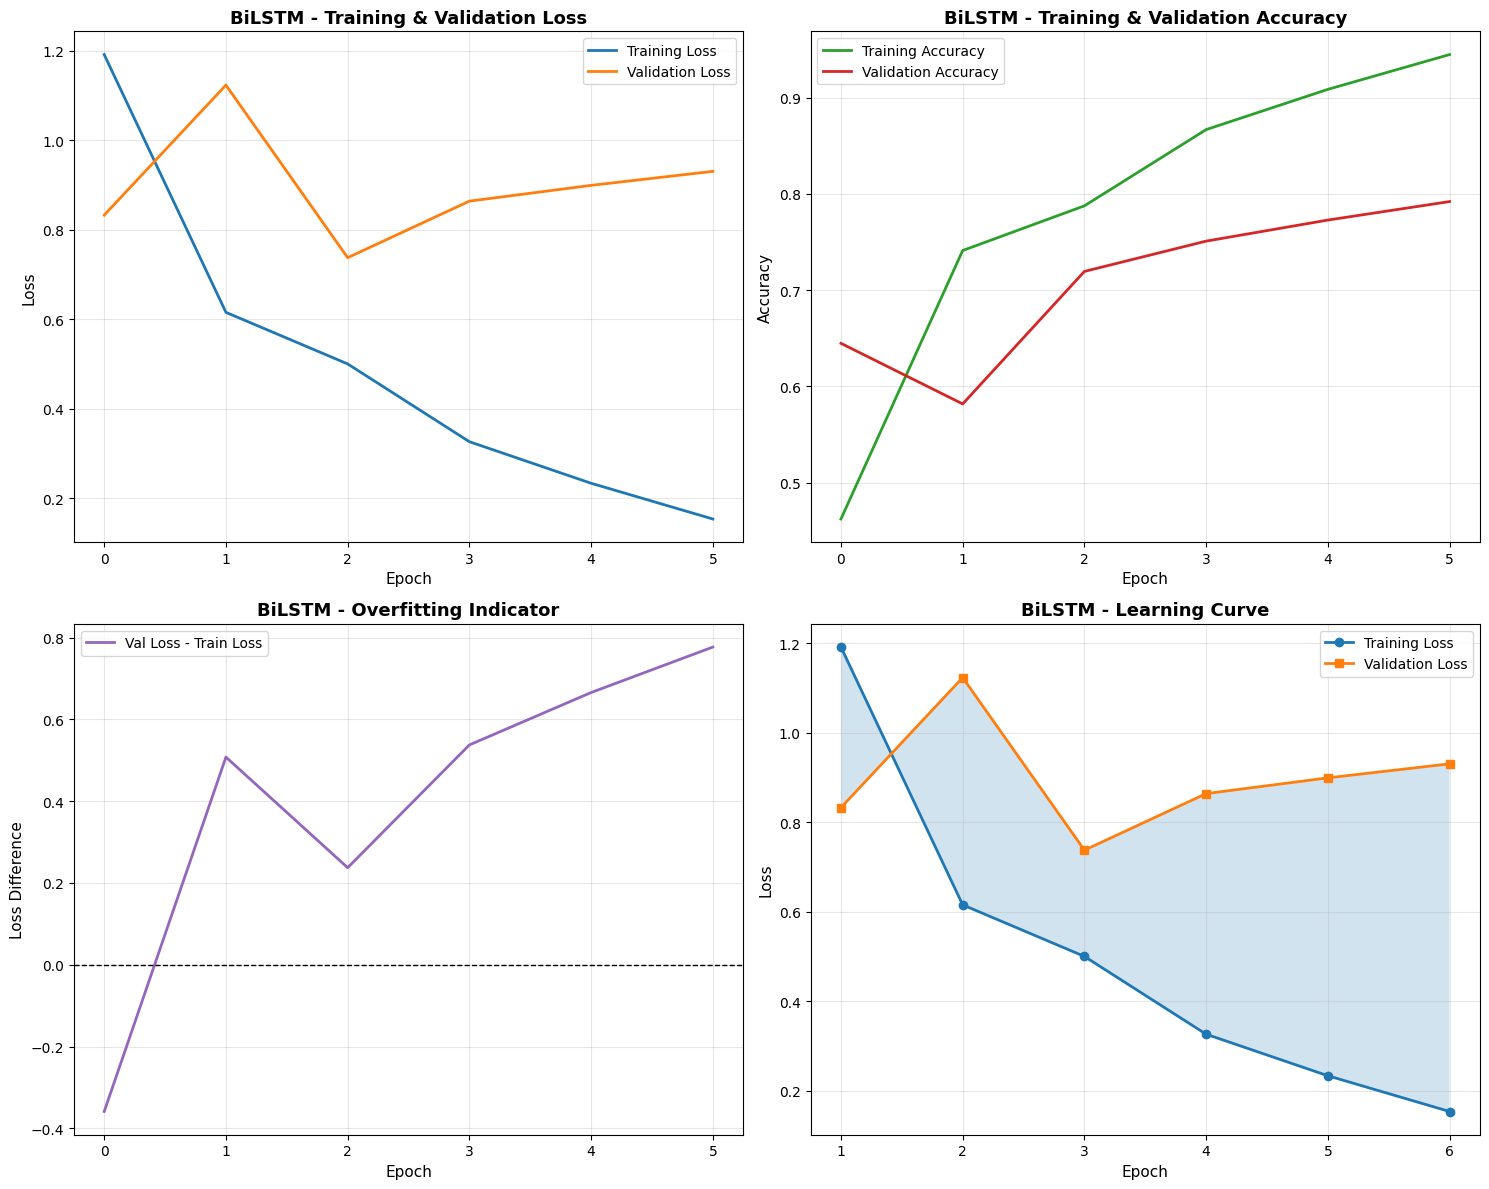

Saved BiLSTM detailed training history plot
BiLSTM Val BA: 0.7104


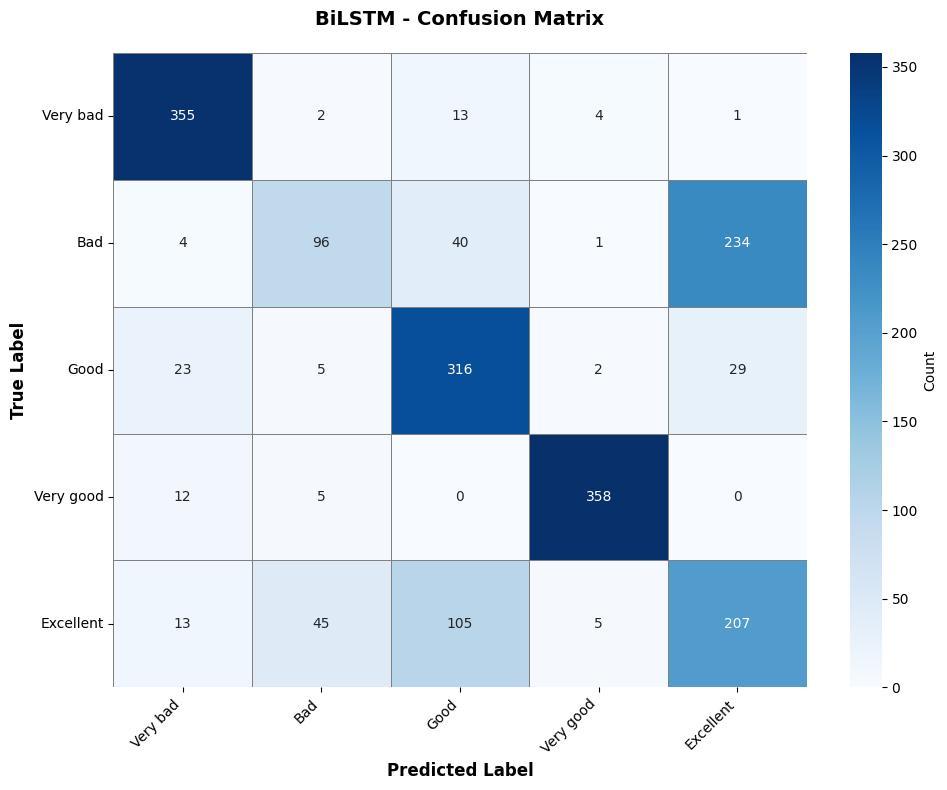

Saved BiLSTM confusion matrix

Training CNN


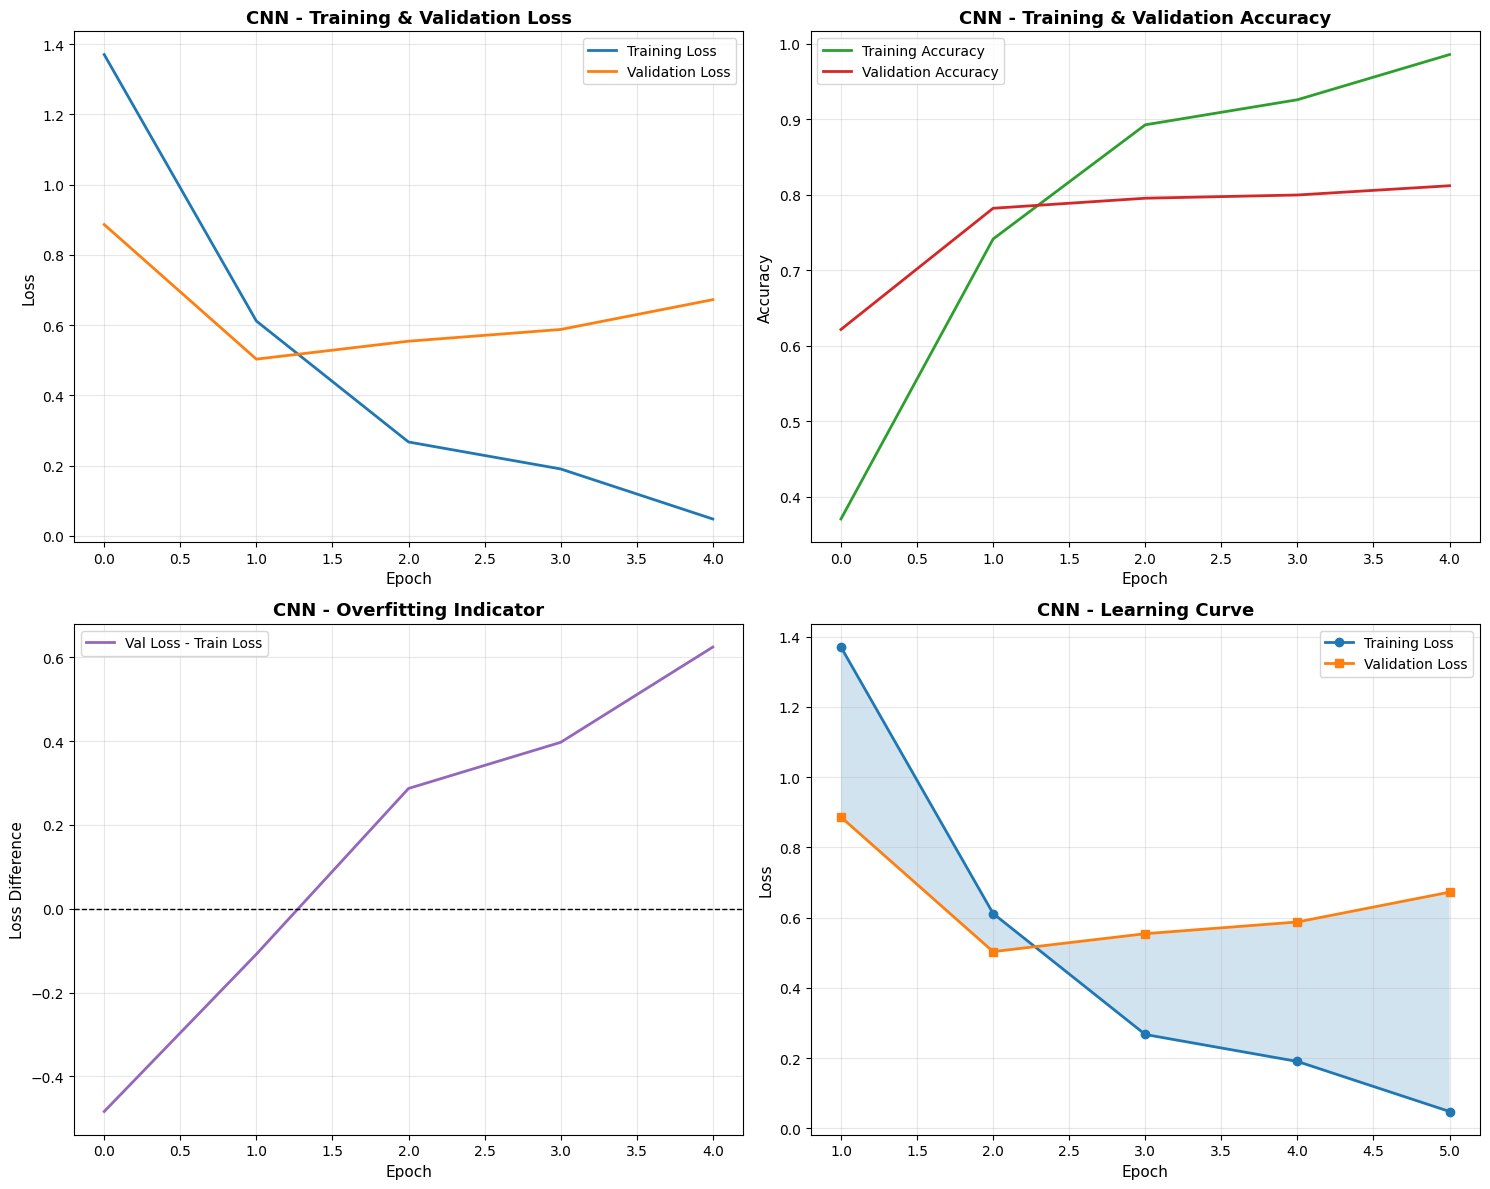

Saved CNN detailed training history plot
CNN Val BA: 0.7819


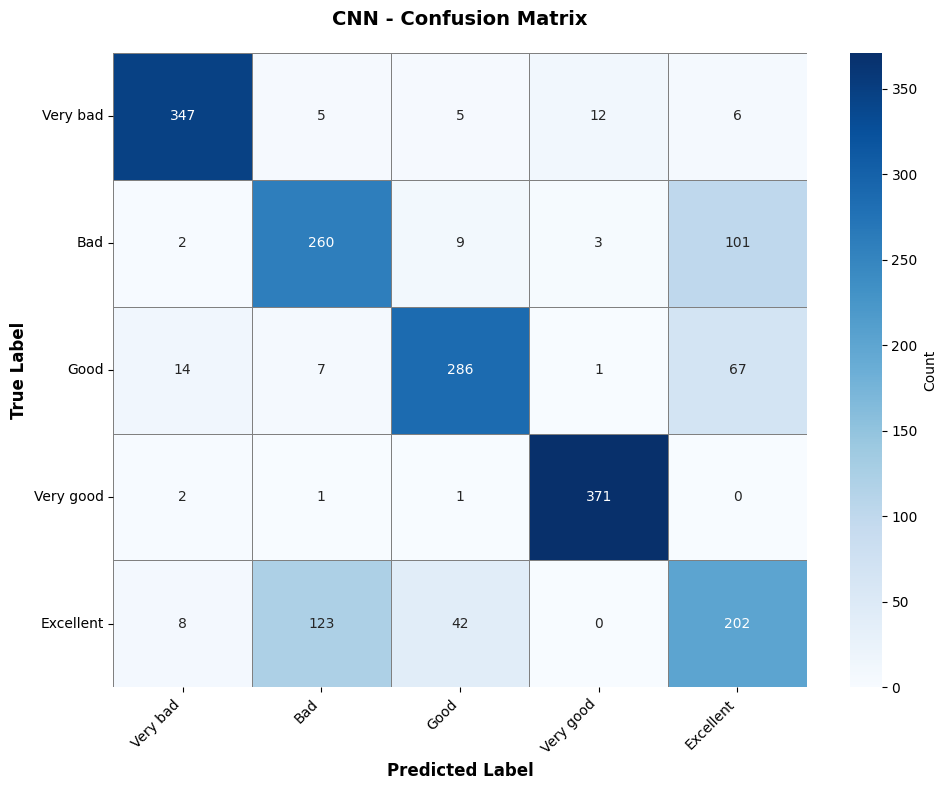

Saved CNN confusion matrix

Training GRU


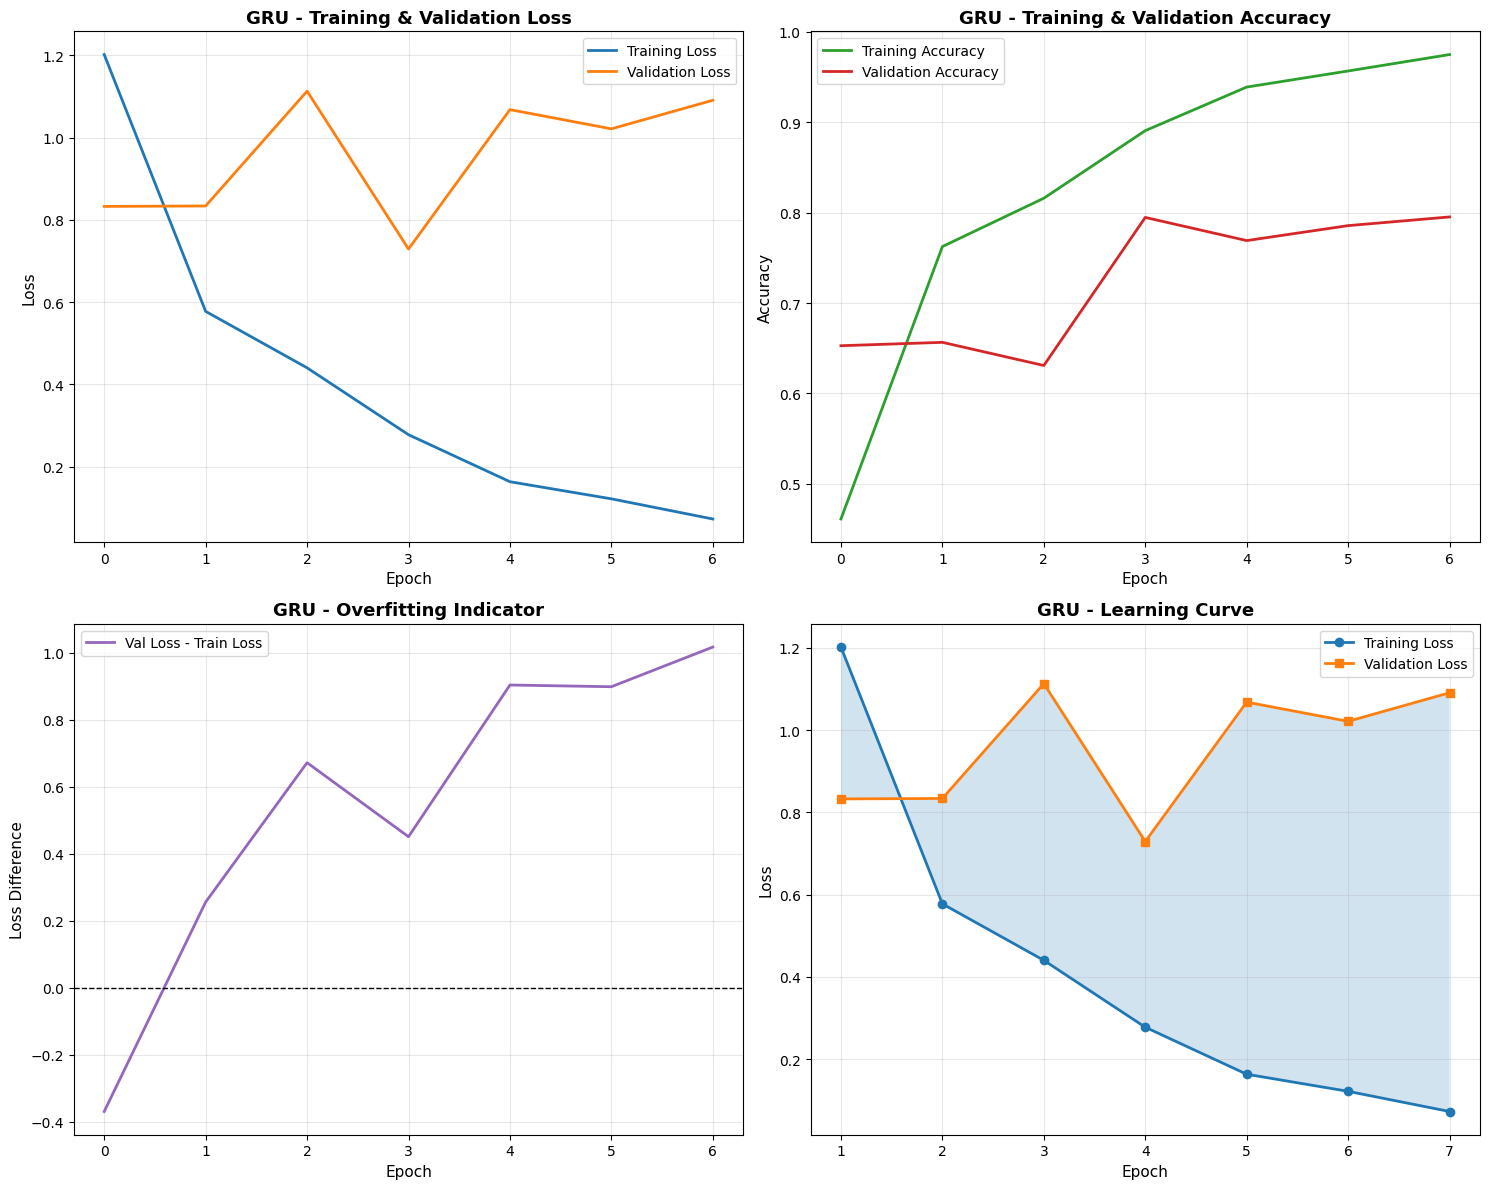

Saved GRU detailed training history plot
GRU Val BA: 0.7909


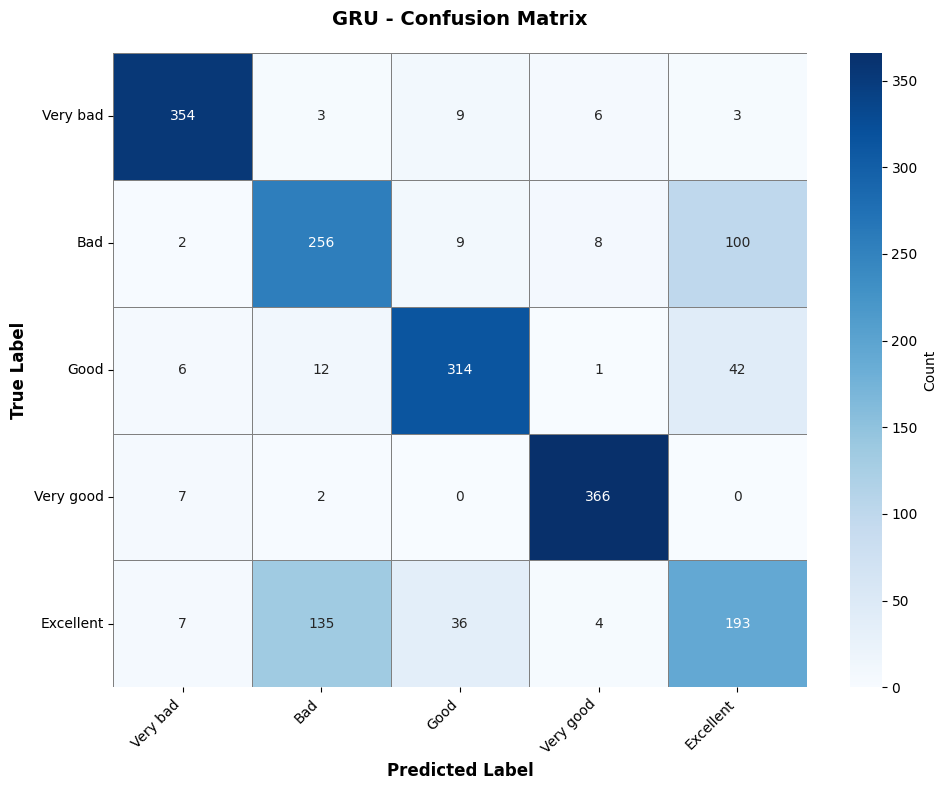

Saved GRU confusion matrix


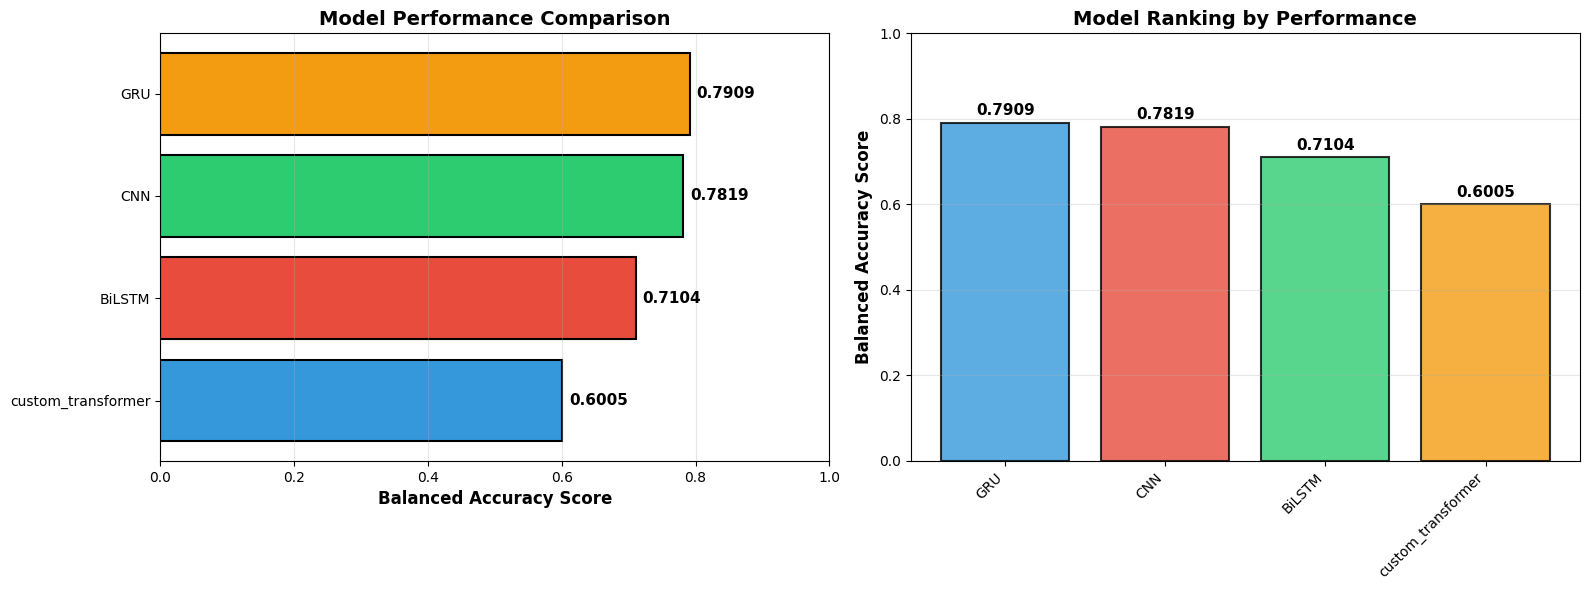

Saved model comparison plot

=== Creating Ensemble ===
custom_transformer: 0.208 (BA: 0.6005)
BiLSTM: 0.246 (BA: 0.7104)
CNN: 0.271 (BA: 0.7819)
GRU: 0.274 (BA: 0.7909)

TRAINING COMPLETE

Model Scores:
  GRU: 0.7909
  CNN: 0.7819
  BiLSTM: 0.7104
  custom_transformer: 0.6005

DONE! Check submission_final_ensemble.csv


In [11]:
#!/usr/bin/env python3

import os
import re
import random
import warnings
import pickle
import numpy as np
import pandas as pd
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import AutoTokenizer, get_cosine_schedule_with_warmup

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

print(f"PyTorch: {torch.__version__}, TensorFlow: {tf.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")

CONFIG = {
    'train_path': '/kaggle/input/inputs/train.csv',
    'test_path': '/kaggle/input/inputs/test.csv',
    'save_dir': '/kaggle/working/',
    
    'pt_max_len': 256,
    'batch_size': 16,
    'accumulation_steps': 2,
    'epochs': 6,
    'learning_rate': 3e-5,
    'val_size': 0.15,
    'pt_weight_decay': 0.01,
    'pt_warmup_ratio': 0.1,
    'pt_dropout': 0.2,
    
    'tf_max_features': 30000,
    'tf_max_len': 200,
    'tf_embedding_dim': 256,
    'tf_batch_size': 64,
    'tf_epochs': 15,
    'tf_learning_rate': 0.001,
    'tf_units': 128,
    'tf_dropout_rate': 0.3,
    
    'label_smoothing': 0.1,
    'focal_gamma': 2.0,
    'target_samples': 2500,
    'seed': 42,
}

CLASS_LABELS = ['Very bad', 'Bad', 'Good', 'Very good', 'Excellent']
NUM_CLASSES = len(CLASS_LABELS)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    tf.random.set_seed(seed)

seed_everything(CONFIG['seed'])

def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s!?.,;:\'-]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

class TextAugmenter:
    def __init__(self):
        self.synonyms = {
            'good': ['great', 'nice', 'excellent', 'wonderful'],
            'bad': ['terrible', 'awful', 'poor', 'horrible'],
            'great': ['excellent', 'wonderful', 'fantastic', 'amazing'],
            'terrible': ['awful', 'horrible', 'dreadful'],
            'love': ['adore', 'enjoy', 'appreciate'],
            'hate': ['despise', 'detest', 'dislike'],
        }
    
    def synonym_replacement(self, text, n=2):
        words = text.split()
        new_words = words.copy()
        replacements = 0
        indices = list(range(len(words)))
        random.shuffle(indices)
        for i in indices:
            if words[i].lower() in self.synonyms and replacements < n:
                new_words[i] = random.choice(self.synonyms[words[i].lower()])
                replacements += 1
        return ' '.join(new_words)
    
    def random_deletion(self, text, p=0.1):
        words = text.split()
        if len(words) <= 3:
            return text
        new_words = [w for w in words if random.random() > p]
        return ' '.join(new_words) if new_words else text
    
    def augment(self, text):
        if random.random() < 0.5:
            return self.synonym_replacement(text)
        return self.random_deletion(text)

def augment_to_target(df, text_col, label_col, target_samples=2500):
    augmenter = TextAugmenter()
    class_counts = df[label_col].value_counts()
    augmented_data = []
    
    for label in class_counts.index:
        label_data = df[df[label_col] == label]
        current_count = len(label_data)
        samples_needed = target_samples - current_count
        
        if samples_needed > 0:
            for _ in range(samples_needed):
                sample = label_data.sample(1).iloc[0]
                aug_text = augmenter.augment(sample[text_col])
                augmented_data.append({
                    text_col: aug_text,
                    label_col: label,
                    'id': -1
                })
    
    if augmented_data:
        aug_df = pd.DataFrame(augmented_data)
        df = pd.concat([df, aug_df], ignore_index=True)
    
    return df

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, label_smoothing=0.1):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.label_smoothing = label_smoothing
    
    def forward(self, logits, targets):
        probs = F.softmax(logits, dim=-1)
        pt = probs.gather(1, targets.unsqueeze(1)).squeeze(1)
        focal_weight = (1 - pt) ** self.gamma
        ce_loss = F.cross_entropy(logits, targets, reduction='none', label_smoothing=self.label_smoothing)
        
        if self.alpha is not None:
            alpha_t = self.alpha.gather(0, targets)
            focal_loss = alpha_t * focal_weight * ce_loss
        else:
            focal_loss = focal_weight * ce_loss
        
        return focal_loss.mean()

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads=8, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(hidden_size, hidden_size * 3)
        self.out = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        B, L, D = x.shape
        qkv = self.qkv(x).reshape(B, L, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        if mask is not None:
            # Convert mask to boolean if it isn't already
            mask = mask.bool()
            attn = attn.masked_fill(~mask.unsqueeze(1).unsqueeze(2), float('-inf'))
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)
        
        out = (attn @ v).transpose(1, 2).reshape(B, L, D)
        return self.out(out)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_size, num_heads=8, ff_dim=2048, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadSelfAttention(hidden_size, num_heads, dropout)
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)
        self.ff = nn.Sequential(
            nn.Linear(hidden_size, ff_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, hidden_size),
            nn.Dropout(dropout)
        )
    
    def forward(self, x, mask=None):
        attn_out = self.attention(x, mask)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x

class CustomTransformerClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes, hidden_size=512, num_layers=6, num_heads=8, max_len=256, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=0)
        self.pos_embedding = nn.Embedding(max_len, hidden_size)
        self.dropout = nn.Dropout(dropout)
        
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(hidden_size, num_heads, hidden_size * 4, dropout)
            for _ in range(num_layers)
        ])
        
        self.norm = nn.LayerNorm(hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        nn.init.normal_(self.embedding.weight, std=0.02)
        nn.init.normal_(self.pos_embedding.weight, std=0.02)
    
    def forward(self, input_ids, attention_mask):
        B, L = input_ids.shape
        positions = torch.arange(L, device=input_ids.device).unsqueeze(0).expand(B, L)
        
        x = self.embedding(input_ids) + self.pos_embedding(positions)
        x = self.dropout(x)
        
        for layer in self.layers:
            x = layer(x, attention_mask)
        
        x = self.norm(x)
        mask_expanded = attention_mask.unsqueeze(-1).expand(x.size()).float()
        sum_hidden = torch.sum(x * mask_expanded, 1)
        sum_mask = mask_expanded.sum(1).clamp(min=1e-9)
        pooled = sum_hidden / sum_mask
        
        return self.classifier(pooled)

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

def train_epoch(model, dataloader, optimizer, scheduler, criterion, device, accumulation_steps):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []
    optimizer.zero_grad()
    
    for step, batch in enumerate(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()
        
        if (step + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        
        total_loss += loss.item() * accumulation_steps
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    return total_loss / len(dataloader), balanced_accuracy_score(all_labels, all_preds)

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return total_loss / len(dataloader), balanced_accuracy_score(all_labels, all_preds)

def predict(model, dataloader, device):
    model.eval()
    all_probs = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask)
            probs = F.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_probs)

def create_bilstm_model(vocab_size, num_classes=5):
    inputs = layers.Input(shape=(CONFIG['tf_max_len'],))
    x = layers.Embedding(vocab_size, CONFIG['tf_embedding_dim'], mask_zero=True)(inputs)
    x = layers.SpatialDropout1D(0.2)(x)
    x = layers.Bidirectional(layers.LSTM(CONFIG['tf_units'], return_sequences=True, dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(CONFIG['tf_units']//2, return_sequences=True, dropout=0.2))(x)
    avg_pool = layers.GlobalAveragePooling1D()(x)
    max_pool = layers.GlobalMaxPooling1D()(x)
    x = layers.concatenate([avg_pool, max_pool])
    x = layers.Dense(256, activation='gelu')(x)
    x = layers.Dropout(CONFIG['tf_dropout_rate'])(x)
    x = layers.Dense(128, activation='gelu')(x)
    x = layers.Dropout(CONFIG['tf_dropout_rate'])(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs=inputs, outputs=outputs)

def create_cnn_model(vocab_size, num_classes=5):
    inputs = layers.Input(shape=(CONFIG['tf_max_len'],))
    x = layers.Embedding(vocab_size, CONFIG['tf_embedding_dim'])(inputs)
    x = layers.SpatialDropout1D(0.2)(x)
    conv_blocks = []
    for kernel_size in [2, 3, 4, 5]:
        conv = layers.Conv1D(CONFIG['tf_units'], kernel_size, activation='relu', padding='same')(x)
        conv = layers.GlobalMaxPooling1D()(conv)
        conv_blocks.append(conv)
    x = layers.concatenate(conv_blocks)
    x = layers.Dense(256, activation='gelu')(x)
    x = layers.Dropout(CONFIG['tf_dropout_rate'])(x)
    x = layers.Dense(128, activation='gelu')(x)
    x = layers.Dropout(CONFIG['tf_dropout_rate'])(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs=inputs, outputs=outputs)

def create_gru_model(vocab_size, num_classes=5):
    inputs = layers.Input(shape=(CONFIG['tf_max_len'],))
    x = layers.Embedding(vocab_size, CONFIG['tf_embedding_dim'], mask_zero=True)(inputs)
    x = layers.SpatialDropout1D(0.2)(x)
    x = layers.Bidirectional(layers.GRU(CONFIG['tf_units'], return_sequences=True, dropout=0.2))(x)
    x = layers.Bidirectional(layers.GRU(CONFIG['tf_units']//2, return_sequences=True, dropout=0.2))(x)
    avg_pool = layers.GlobalAveragePooling1D()(x)
    max_pool = layers.GlobalMaxPooling1D()(x)
    x = layers.concatenate([avg_pool, max_pool])
    x = layers.Dense(256, activation='gelu')(x)
    x = layers.Dropout(CONFIG['tf_dropout_rate'])(x)
    x = layers.Dense(128, activation='gelu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs=inputs, outputs=outputs)

def plot_pytorch_training_history(train_losses, train_accs, val_losses, val_accs, model_name):
    """Visualize PyTorch training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(train_losses) + 1)
    
    # Loss plot
    ax1.plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=8)
    ax1.plot(epochs, val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=8)
    ax1.set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax2.plot(epochs, train_accs, 'b-o', label='Training Balanced Accuracy', linewidth=2, markersize=8)
    ax2.plot(epochs, val_accs, 'r-s', label='Validation Balanced Accuracy', linewidth=2, markersize=8)
    ax2.set_title(f'{model_name} - Balanced Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Balanced Accuracy', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['save_dir'], f'{model_name}_training_history.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved {model_name} training history plot")

def plot_tf_training_history(history, model_name):
    """Visualize TensorFlow/Keras training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Loss
    axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2, color='#1f77b4')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='#ff7f0e')
    axes[0, 0].set_title(f'{model_name} - Training & Validation Loss', fontsize=13, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch', fontsize=11)
    axes[0, 0].set_ylabel('Loss', fontsize=11)
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='#2ca02c')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='#d62728')
    axes[0, 1].set_title(f'{model_name} - Training & Validation Accuracy', fontsize=13, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch', fontsize=11)
    axes[0, 1].set_ylabel('Accuracy', fontsize=11)
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Loss difference
    loss_diff = np.array(history.history['val_loss']) - np.array(history.history['loss'])
    axes[1, 0].plot(loss_diff, label='Val Loss - Train Loss', linewidth=2, color='#9467bd')
    axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
    axes[1, 0].set_title(f'{model_name} - Overfitting Indicator', fontsize=13, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch', fontsize=11)
    axes[1, 0].set_ylabel('Loss Difference', fontsize=11)
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Learning curve
    epochs = range(1, len(history.history['loss']) + 1)
    axes[1, 1].plot(epochs, history.history['loss'], 'o-', label='Training Loss', linewidth=2, markersize=6)
    axes[1, 1].plot(epochs, history.history['val_loss'], 's-', label='Validation Loss', linewidth=2, markersize=6)
    axes[1, 1].fill_between(epochs, history.history['loss'], history.history['val_loss'], alpha=0.2)
    axes[1, 1].set_title(f'{model_name} - Learning Curve', fontsize=13, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch', fontsize=11)
    axes[1, 1].set_ylabel('Loss', fontsize=11)
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['save_dir'], f'{model_name}_detailed_history.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved {model_name} detailed training history plot")

def plot_confusion_matrix(y_true, y_pred, model_name, class_labels):
    """Plot confusion matrix for model predictions"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels,
                cbar_kws={'label': 'Count'}, linewidths=0.5, linecolor='gray')
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['save_dir'], f'{model_name}_confusion_matrix.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved {model_name} confusion matrix")

def plot_model_comparison(all_scores):
    """Plot comparison of all model scores"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    models = list(all_scores.keys())
    scores = list(all_scores.values())
    
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    
    # Bar plot
    bars = ax1.barh(models, scores, color=colors, edgecolor='black', linewidth=1.5)
    ax1.set_xlabel('Balanced Accuracy Score', fontsize=12, fontweight='bold')
    ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
    ax1.set_xlim(0, 1)
    ax1.grid(axis='x', alpha=0.3)
    
    for i, (bar, score) in enumerate(zip(bars, scores)):
        ax1.text(score + 0.01, i, f'{score:.4f}', va='center', fontsize=11, fontweight='bold')
    
    # Sorted bar plot
    sorted_items = sorted(zip(models, scores), key=lambda x: x[1], reverse=True)
    sorted_models, sorted_scores = zip(*sorted_items)
    
    bars2 = ax2.bar(range(len(sorted_models)), sorted_scores, color=colors, 
                     edgecolor='black', linewidth=1.5, alpha=0.8)
    ax2.set_xticks(range(len(sorted_models)))
    ax2.set_xticklabels(sorted_models, rotation=45, ha='right')
    ax2.set_ylabel('Balanced Accuracy Score', fontsize=12, fontweight='bold')
    ax2.set_title('Model Ranking by Performance', fontsize=14, fontweight='bold')
    ax2.set_ylim(0, 1)
    ax2.grid(axis='y', alpha=0.3)
    
    for bar, score in zip(bars2, sorted_scores):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{score:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['save_dir'], 'model_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved model comparison plot")

def train_custom_transformer(train_df, test_df, tokenizer, class_weights):
    print("\n=== Training Custom Transformer ===")
    
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_df['cleaned_text'].values,
        train_df['label_idx'].values,
        test_size=CONFIG['val_size'],
        stratify=train_df['label_idx'].values,
        random_state=CONFIG['seed']
    )
    
    train_dataset = TextDataset(train_texts, train_labels, tokenizer, CONFIG['pt_max_len'])
    val_dataset = TextDataset(val_texts, val_labels, tokenizer, CONFIG['pt_max_len'])
    test_dataset = TextDataset(test_df['cleaned_text'].values, np.zeros(len(test_df)), tokenizer, CONFIG['pt_max_len'])
    
    class_weights_pt = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
    sample_weights = class_weights_pt[train_labels].cpu().numpy()
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
    
    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size']*2, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size']*2, shuffle=False)
    
    vocab_size = len(tokenizer)
    model = CustomTransformerClassifier(vocab_size, NUM_CLASSES, hidden_size=512, num_layers=6, 
                                       num_heads=8, max_len=CONFIG['pt_max_len'], 
                                       dropout=CONFIG['pt_dropout']).to(DEVICE)
    
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['pt_weight_decay'])
    total_steps = len(train_loader) * CONFIG['epochs'] // CONFIG['accumulation_steps']
    warmup_steps = int(total_steps * CONFIG['pt_warmup_ratio'])
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    criterion = FocalLoss(alpha=class_weights_pt, gamma=CONFIG['focal_gamma'], label_smoothing=CONFIG['label_smoothing'])
    
    best_val_acc = 0
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    
    for epoch in range(CONFIG['epochs']):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, criterion, DEVICE, CONFIG['accumulation_steps'])
        val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{CONFIG['epochs']} | Train Loss: {train_loss:.4f} BA: {train_acc:.4f} | Val Loss: {val_loss:.4f} BA: {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), os.path.join(CONFIG['save_dir'], 'custom_transformer.pt'))
    
    # Plot PyTorch training history
    plot_pytorch_training_history(train_losses, train_accs, val_losses, val_accs, 'Custom Transformer')
    
    model.load_state_dict(torch.load(os.path.join(CONFIG['save_dir'], 'custom_transformer.pt')))
    
    # Get predictions for confusion matrix
    model.eval()
    val_preds = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
    
    plot_confusion_matrix(val_labels, val_preds, 'Custom Transformer', CLASS_LABELS)
    
    test_probs = predict(model, test_loader, DEVICE)
    print(f"Custom Transformer Best Val BA: {best_val_acc:.4f}")
    return test_probs, best_val_acc

def train_all_models():
    print("="*60)
    print("TRAINING ALL MODELS")
    print("="*60)
    
    os.makedirs(CONFIG['save_dir'], exist_ok=True)
    
    train_df = pd.read_csv(CONFIG['train_path'])
    test_df = pd.read_csv(CONFIG['test_path'])
    
    train_df['cleaned_text'] = train_df['text'].apply(clean_text)
    test_df['cleaned_text'] = test_df['text'].apply(clean_text)
    
    le = LabelEncoder()
    le.fit(CLASS_LABELS)
    train_df['label_idx'] = le.transform(train_df['review'])
    
    train_df = augment_to_target(train_df, 'cleaned_text', 'review', CONFIG['target_samples'])
    train_df['label_idx'] = le.transform(train_df['review'])
    
    class_counts = np.bincount(train_df['label_idx'].values, minlength=NUM_CLASSES)
    class_weights = 1.0 / (class_counts + 1e-6)
    class_weights = class_weights / class_weights.sum() * NUM_CLASSES
    
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    
    transformer_probs, transformer_score = train_custom_transformer(train_df, test_df, tokenizer, class_weights)
    
    print("\n=== Training TensorFlow Models ===")
    X_train, X_val, y_train, y_val = train_test_split(
        train_df['cleaned_text'].values, train_df['label_idx'].values,
        test_size=0.15, stratify=train_df['label_idx'].values, random_state=CONFIG['seed']
    )
    
    vectorize_layer = layers.TextVectorization(
        max_tokens=CONFIG['tf_max_features'],
        output_mode='int',
        output_sequence_length=CONFIG['tf_max_len']
    )
    vectorize_layer.adapt(np.concatenate([X_train, X_val]))
    vocab_size = len(vectorize_layer.get_vocabulary())
    
    X_train_vec = vectorize_layer(X_train).numpy()
    X_val_vec = vectorize_layer(X_val).numpy()
    X_test_vec = vectorize_layer(test_df['cleaned_text'].values).numpy()
    
    tf_class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    tf_class_weights_dict = {i: w for i, w in enumerate(tf_class_weights)}
    
    tf_models = [
        ('BiLSTM', create_bilstm_model),
        ('CNN', create_cnn_model),
        ('GRU', create_gru_model)
    ]
    
    all_predictions = {'custom_transformer': transformer_probs}
    all_scores = {'custom_transformer': transformer_score}
    
    for name, builder in tf_models:
        print(f"\nTraining {name}")
        model = builder(vocab_size)
        model.compile(
            optimizer=keras.optimizers.Adam(CONFIG['tf_learning_rate']),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        callbacks = [
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)
        ]
        
        history = model.fit(X_train_vec, y_train, validation_data=(X_val_vec, y_val),
                           epochs=CONFIG['tf_epochs'], batch_size=CONFIG['tf_batch_size'],
                           class_weight=tf_class_weights_dict, callbacks=callbacks, verbose=0)
        
        # Plot TensorFlow training history
        plot_tf_training_history(history, name)
        
        model.save(os.path.join(CONFIG['save_dir'], f'{name}_model.keras'))
        
        y_pred = np.argmax(model.predict(X_val_vec, verbose=0), axis=1)
        ba = balanced_accuracy_score(y_val, y_pred)
        print(f"{name} Val BA: {ba:.4f}")
        
        # Plot confusion matrix for TensorFlow models
        plot_confusion_matrix(y_val, y_pred, name, CLASS_LABELS)
        
        test_probs = model.predict(X_test_vec, verbose=0)
        all_predictions[name] = test_probs
        all_scores[name] = ba
    
    # Plot model comparison
    plot_model_comparison(all_scores)
    
    print("\n=== Creating Ensemble ===")
    total_weight = sum(all_scores.values())
    ensemble_probs = np.zeros((len(test_df), NUM_CLASSES))
    
    for name, probs in all_predictions.items():
        weight = all_scores[name] / total_weight
        ensemble_probs += probs * weight
        print(f"{name}: {weight:.3f} (BA: {all_scores[name]:.4f})")
    
    ensemble_preds = np.argmax(ensemble_probs, axis=1)
    ensemble_labels = le.inverse_transform(ensemble_preds)
    submission = pd.DataFrame({'id': test_df['id'], 'review': ensemble_labels})
    submission.to_csv('submission_final_ensemble.csv', index=False)
    
    for name, probs in all_predictions.items():
        preds = np.argmax(probs, axis=1)
        labels = le.inverse_transform(preds)
        sub = pd.DataFrame({'id': test_df['id'], 'review': labels})
        sub.to_csv(f'submission_{name}.csv', index=False)
    
    print("\n" + "="*60)
    print("TRAINING COMPLETE")
    print("="*60)
    print("\nModel Scores:")
    for name, score in sorted(all_scores.items(), key=lambda x: -x[1]):
        print(f"  {name}: {score:.4f}")
    
    return all_scores

if __name__ == '__main__':
    train_all_models()
    print("\nDONE! Check submission_final_ensemble.csv")
